# Evaluating California Real Estate Market by Price-to-Rent Ratio

Categories of Interest:

Property Tax Rate (Average)

In [246]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [247]:
def rename_col():
    years_list = list(range(2010,2017))
    col_list = []
    for year in years_list:
        col_list.append("{}".format(year))
    return col_list

def repeat_col(df,col_name):
    col_list = list(df.columns.values)
    for col,i in enumerate(col_list):
        if i != "CountyName":
            col_list[col] = col_name
    return col_list

def rename_headers(df,col_name):
    level_headers(df)
    df.columns = rename_col(col_name)

def level_headers(df):
    df.reset_index(inplace=True)
    df.columns = df.columns.get_level_values(0)

## Reading & Cleaning Data

### 1) Price-to-rent data

In [248]:
pr = pd.read_csv("pricetorentratio.csv")
pr.head(3)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02
0,61639,10025,New York,NY,New York,New York,1,18.74,18.92,19.07,19.40,19.89,20.20,20.53,20.60,20.50,20.40,20.31,20.09,20.11,20.56,20.40,19.70,19.62,19.49,19.35,19.57,19.85,19.58,19.17,19.31,19.50,19.71,19.49,19.55,20.29,20.56,20.75,20.35,20.29,21.00,22.01,21.70,21.70,22.73,22.39,22.15,22.35,22.58,24.19,24.08,23.99,23.82,23.22,23.06,23.37,23.41,23.76,24.22,24.06,24.37,24.30,24.79,25.23,26.06,26.56,26.58,25.85,25.25,23.29,23.46,23.59,24.17,23.75,22.05,22.89,23.61,24.41,24.76,24.67,25.03,25.17,24.75,24.77,24.91,24.60,25.48,26.20,26.33,26.48,26.11,26.52,26.48,26.38,26.27,26.01
1,84654,60657,Chicago,IL,Chicago,Cook,2,13.27,13.20,13.20,13.31,13.36,13.50,13.23,13.10,12.98,12.68,12.58,12.46,12.46,12.35,12.34,12.42,12.22,11.96,11.93,11.90,11.84,11.88,12.16,12.15,12.08,12.11,12.18,12.05,12.03,11.96,12.01,12.18,12.00,11.89,11.78,11.96,12.28,12.47,12.56,12.84,12.94,12.79,12.61,12.57,12.51,12.32,12.23,12.26,12.33,12.30,12.36,12.57,12.43,12.48,12.40,12.38,12.37,12.36,12.33,12.39,12.27,12.30,12.41,12.36,12.45,12.36,12.36,12.53,12.45,12.45,12.38,12.40,12.52,12.68,12.85,12.99,13.07,13.12,13.11,13.02,12.85,12.80,12.75,12.70,12.78,13.00,13.05,13.05,13.10
2,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,3,9.51,9.51,9.47,9.43,9.45,9.47,9.43,9.38,9.30,9.23,9.18,9.15,9.15,9.18,9.19,9.18,9.17,9.15,9.13,9.11,9.11,9.11,9.11,9.13,9.16,9.24,9.34,9.38,9.38,9.43,9.51,9.55,9.60,9.64,9.69,9.73,9.81,9.84,9.87,9.91,9.85,9.84,10.02,10.13,10.24,10.24,10.28,10.31,10.38,10.61,10.75,10.82,10.89,10.98,11.06,11.18,11.31,11.45,11.51,11.61,11.70,11.77,11.97,12.12,12.26,12.40,12.40,12.41,12.49,12.55,12.58,12.66,12.70,12.80,12.86,12.94,13.04,13.20,13.28,13.37,13.33,13.25,13.25,13.40,13.57,13.61,13.65,13.68,13.73


In [249]:
# extracting CA real estate data from US real estate data using CA zip codes
# load california zip codes
ca_zip = pd.read_csv("CAzipcodes.csv")
#ca_zip.head(1)

In [250]:
# change zip_code column name to match "RegionName" in price-to-rent dataset
ca_zip.columns = ["RegionName"]
#ca_zip.head(1)

In [251]:
# merge ca_zip & pr to extract CA price-to-rent data, save merged dataframe into new variable "ca_pr"
ca_pr = pd.merge(pr,ca_zip)        
ca_pr.head(3)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02
0,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,19.37,19.14,18.91,18.75,18.82,18.66,18.62,18.73,18.65,18.64,18.06,17.71,17.71,17.66,17.63,17.60,17.85,17.64,17.81,18.05,17.84,17.86,18.08,18.52,19.11,19.70,19.32,18.99,19.16,19.56,19.84,19.50,19.54,19.41,19.16,19.31,19.29,19.21,19.15,19.40,19.88,20.43,20.60,20.70,20.79,20.41,19.99,19.79,19.76,19.65,19.52,19.22,19.08,19.27,19.61,19.80,19.92,20.09,20.31,20.15,19.54,19.52,19.27,19.35,19.24,19.53,19.82,20.11,20.22,20.00,19.68,19.69,19.70,20.17,20.39,20.46,20.49,20.74,21.23,21.30,21.46,21.41,21.28,21.38,21.66,22.21,22.53,22.04,22.17
1,96107,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,16,14.53,14.50,14.40,14.28,14.18,14.10,14.08,14.07,14.06,13.97,14.02,14.04,14.01,14.09,14.24,14.31,14.15,14.13,14.17,14.28,14.29,14.66,14.56,14.74,14.70,14.63,14.63,14.82,15.00,15.24,15.48,15.59,15.73,15.94,16.18,16.34,16.46,16.63,16.79,17.04,17.25,17.43,17.51,17.79,17.70,17.38,17.33,17.24,17.28,17.17,16.88,16.74,16.56,16.50,16.73,16.84,16.81,16.94,16.92,17.12,17.21,17.22,17.33,17.13,17.33,17.09,17.04,17.00,17.03,17.51,17.40,17.40,17.48,17.66,17.81,17.87,17.93,18.03,17.98,17.81,17.80,17.78,17.85,17.95,17.97,17.97,18.08,18.09,18.23
2,97771,94565,Pittsburg,CA,San Francisco,Contra Costa,24,8.91,8.84,8.67,8.80,8.80,8.79,8.73,8.62,8.53,8.42,8.35,8.33,8.33,8.36,8.43,8.48,8.51,8.56,8.57,8.59,8.59,8.61,8.71,8.82,8.94,9.11,9.27,9.31,9.36,9.52,9.74,10.03,10.46,10.87,11.34,11.60,11.83,12.15,12.34,12.39,12.57,12.78,13.21,13.51,13.75,13.93,13.98,13.97,13.89,13.83,13.81,13.77,13.84,13.93,14.04,14.11,14.11,14.06,14.03,14.10,14.19,14.23,14.22,14.03,13.89,13.85,13.81,13.94,13.97,13.99,14.06,14.18,14.33,14.48,14.56,14.60,14.69,14.73,14.80,14.91,14.92,14.91,14.87,14.85,14.91,14.92,15.03,15.05,15.29


### 2) Unemployment Rate (%) 2010-2016

In [252]:
path = os.getcwd()
files = os.listdir(path)
lfd_xlsx = [f for f in files if f[-4:]=='xlsx' and f[0:3]=='lfd']
lfd = pd.DataFrame()
for f in lfd_xlsx:
    data = pd.read_excel(f)
    lfd = lfd.append(data)
    
lfd.columns = lfd.iloc[4]
lfd.columns = ['LAUS','2011','2012','2013','2014','2015','2016','STATEFIPSCODE','COUNTYFIPSCODE','COUNTYNAME/STATEABBR','YEAR','_','LABORFORCE','EMPLOYED','UNEMPLOYED','UNEMPLOYMENTRATE(%)']
lfd = lfd.iloc[5:]
lfd['CountyName'],lfd['STATEABBR'] = lfd['COUNTYNAME/STATEABBR'].str.split(',',1).str
lfd = lfd.drop(lfd.columns[[0,1,2,3,4,5,6,7,8,9,11]],axis=1)
lfd = lfd.dropna(how="any")
lfd = lfd.loc[lfd['STATEABBR']==' CA']

In [292]:
# changing county names to match price-to-rent county names for merge
lfd["CountyName"] = lfd["CountyName"].apply(lambda x: ' '.join([w for w in x.split() if not 'County' in w]))
# extract unemployment rate (%) per year
unemployment_rate = lfd.pivot_table(index="CountyName",columns="YEAR",values=["UNEMPLOYMENTRATE(%)"],aggfunc="first")
level_headers(unemployment_rate)
unemployment_rate.columns.values[1:8] = rename_col()
unemployment_rate.head(3)
#print(lfd_year.to_string())

,CountyName,2010,2011,2012,2013,2014,2015,2016
0,Alameda,10.9,10.1,8.7,7.2,5.8,4.7,4.2
1,Alpine,12.9,12.8,11.2,9.7,8.2,7.3,6.5
2,Amador,14.1,13.6,12.3,10.3,8.3,6.6,5.9


### 3) Population Total 2010-2016

In [254]:
f = pd.ExcelFile("CAcountypop.xlsx")
pop = pd.DataFrame()
year = 2010
for sheet in f.sheet_names:
    if "E5CountyState" in sheet and "2017" not in sheet:
            sub_pop = pd.read_excel(f,sheet,skiprows=3).assign(Year=year)
            pop = pop.append(sub_pop)
            year += 1
    
pop = pop[["COUNTY","Total","Total.1","Vacancy Rate","Year"]]
pop.columns = ["CountyName","Population Total","Housing Units Total","Vacancy Rate","Year"]
pop = pop.drop(pop.index[[59]])
pop = pop.dropna(how="any")
#display(pop)
#print(list(pop.columns.values))
#print(pop.to_string())

In [293]:
# extract population totals per year
pop_year = pop.pivot_table(index="CountyName",columns="Year",values=["Population Total"],aggfunc="first")
level_headers(pop_year)
pop_year.columns.values[1:8] = rename_col()
pop_year.head(3)
#display(pop_year)

,CountyName,2010,2011,2012,2013,2014,2015,2016
0,Alameda,1510271.0,1525695.0,1543027.0,1567091.0,1588348.0,1611318.0,1629233.0
1,Alpine,1175.0,1169.0,1166.0,1164.0,1163.0,1163.0,1160.0
2,Amador,38091.0,38011.0,37945.0,37304.0,37815.0,37764.0,37667.0


 ### 3) Vacancy Rate 2010-2016

In [294]:
vacancy_year = pop.pivot_table(index="CountyName",columns="Year",values=["Vacancy Rate"],aggfunc="first")
level_headers(vacancy_year)
vacancy_year.columns.values[1:8] = rename_col()
vacancy_year.head(3)

,CountyName,2010,2011,2012,2013,2014,2015,2016
0,Alameda,0.064203,0.063045,0.057916,0.051747,0.050178,0.048556,0.041431
1,Alpine,0.717614,0.717701,0.718661,0.719932,0.720406,0.720970,0.722722
2,Amador,0.192047,0.192977,0.197228,0.201992,0.203116,0.204261,0.204238


### 4) Housing Units 2010-2016

In [296]:
housing_units_year = pop.pivot_table(index="CountyName",columns="Year",values=["Housing Units Total"],aggfunc="first")
level_headers(housing_units_year)
housing_units_year.columns.values[1:8] = rename_col()
housing_units_year.head(3)

,CountyName,2010,2011,2012,2013,2014,2015,2016
0,Alameda,581372.0,582727.0,584049.0,586474.0,588948.0,591235.0,593662.0
1,Alpine,1760.0,1757.0,1763.0,1771.0,1774.0,1774.0,1778.0
2,Amador,18032.0,18054.0,18111.0,18174.0,18167.0,18163.0,18170.0


### 5) Crime Rate 2010-2016

In [258]:
crime = pd.read_csv("CAcrimes.csv",sep=',', error_bad_lines=False, index_col=False, dtype='unicode')
# change dtype for dataframe fr. objects to integers
crime = crime.apply(pd.to_numeric,errors="ignore")
# change persistent object types to integers 
crime_obj = ["TotalStructural_sum","TotalMobile_sum","TotalOther_sum","GrandTotal_sum","GrandTotClr_sum"]
for obj in crime_obj:
    crime[obj] = pd.to_numeric(crime[obj],errors="coerce")
# sum selected column data for total crime
col_list = list(crime)
col_list = [col for col in col_list if col not in {'Year','County','NCICCode'}]
crime["Total Crime"] = crime[col_list].sum(axis=1)
# select only Years 2010-2016
crime = crime[(crime["Year"] >= 2010) & (crime["Year"] < 2017)]
crime = crime.rename(columns={"County":"CountyName"})
crime["CountyName"] = crime["CountyName"].apply(lambda x: ' '.join([w for w in x.split() if not 'County' in w]))
#print(col_list)
#crime.head(3)
#crime.dtypes

In [259]:
# consolidate total crimes per year
crime_year = crime.pivot_table(index="CountyName",columns="Year",values=["Total Crime"],aggfunc="first")
level_headers(crime_year)
#crime_year.head(3)
#display(crime_year)

In [260]:
# calculate crime rate 
crime_rate = crime_year.iloc[:,1:]/pop_year.iloc[:,1:].values
crime_rate.columns = rename_col()
crime_rate["CountyName"] = crime_year["CountyName"]
crime_rate.head(3)
#display(crime_rate)

,2010,2011,2012,2013,2014,2015,2016,CountyName
0,0.008299,0.008150,0.008993,0.008165,0.007104,0.006690,0.007222,Alameda
1,0.305532,0.415740,0.179245,0.152921,0.110060,0.177988,0.144828,Alpine
2,0.069386,0.082003,0.068178,0.066481,0.056776,0.050763,0.056761,Amador


### 6) School Total 2010-2016

#### A) Private Schools

In [261]:
ps_xls = [f for f in files if f[-3:]=='xls' and f[0:2]=='ps']
ps_data = pd.DataFrame()
year = 2010
for f in ps_xls:
    data = pd.read_excel(f,skiprows=3).assign(Year=year)
    ps_data = ps_data.append(data)
    year += 1

ps_data = ps_data[["County","Year"]]
ps_data = ps_data.dropna(how="any")
ps_data["Private_School_Count"] = 1
ps_data = ps_data.rename(columns={"County":"CountyName"})
#ps_data.head(3)
#display(ps_data)
#ps_data.head(3)

In [262]:
# modify data to extract number of private schools per year
ps = ps_data.pivot_table(index="CountyName",columns="Year",values=["Private_School_Count"],aggfunc="sum")
ps = ps.fillna(0)
ps_year = ps
level_headers(ps_year)
ps_year = ps_year.drop(ps_year.index[[51]])
#ps_year.head(3)
#display(ps_year)
#print(ps_year.to_string())

#### B) Public Schools

In [263]:
pubs_data = pd.read_excel("pubschls.xlsx")

pubs_data = pubs_data[["County","OpenDate","ClosedDate","LastUpDate"]]
pubs_data["TMP"] = pubs_data.OpenDate.values # create temporary column out of the index
pubs_data = pubs_data[pubs_data.TMP.notnull()] # remove all NaT values
pubs_data.drop(["TMP"], axis=1, inplace=True) # delete temporary column 
pubs_data["OpenYear"] = pd.DatetimeIndex(pubs_data['OpenDate']).year
pubs_data["ClosedYear"] = pd.DatetimeIndex(pubs_data['ClosedDate']).year
for year in range(2010, 2017):
    # Create a column of 0s
    pubs_data[year] = 0
    # Where the year is between OpenYear and ClosedYear (or closed year is NaN) set it to 1
    pubs_data.loc[(pubs_data['OpenYear'] <= year) & ((pubs_data['ClosedYear'].isnull()) | (pubs_data['ClosedYear'] >= year)), year] += int(1)
pubs_data = pubs_data.rename(columns={"County":"CountyName"})
#pubs_data.head(3)

In [264]:
# consolidate number of public schools per year
pubs_year = pubs_data[["CountyName",2010,2011,2012,2013,2014,2015,2016]]
pubs_year = pubs_year.groupby(["CountyName"]).sum()
level_headers(pubs_year)
#pubs_year.head(3)
#display(pubs_year)

#### C) Total Number of Schools

In [304]:
col_list = ["CountyName","2010","2011","2012","2013","2014","2015","2016"]
pub = pubs_year
pub.columns = col_list
priv = ps
#priv.reset_index(inplace=True)
priv.columns = priv.columns.get_level_values(0)
priv.columns = col_list

# add public schools and private schools together to get total number of schools per year
sch_total = pub.iloc[:,1:].add(priv.iloc[:,1:],fill_value=0)
sch_total["CountyName"] = pub["CountyName"]
#display(sch_total)
sch_total.head(3)

,2010,2011,2012,2013,2014,2015,2016,CountyName
0,580.0,568.0,576.0,560.0,557.0,556.0,549.0,Alameda
1,7.0,4.0,4.0,4.0,3.0,3.0,3.0,Alpine
2,18.0,18.0,16.0,16.0,17.0,16.0,17.0,Amador


### 7) Building Permits 2010-2016

In [274]:
bp_xls = [f for f in files if f[-3:]=='csv' and f[0:2]=='bp']
bp_data = pd.DataFrame()
for f in bp_xls:
    data = pd.read_csv(f,sep=',', error_bad_lines=False, index_col=False, dtype='unicode')
    bp_data = bp_data.append(data)

bp_data = bp_data.iloc[2:,:]
bp_data = bp_data[["Survey","FIPS","County","Unnamed: 6","Unnamed: 9","Unnamed: 12","Unnamed: 15"]]
# extract CA building permits fr. US data
bp_data["FIPS"] = bp_data["FIPS"].apply(pd.to_numeric,errors="coerce")
bp_data = bp_data[bp_data["FIPS"]==6]
bp_data.columns = ["Year","FIPS","CountyName","1_unit_bldgs","2_unit_bldgs","3-4_unit_bldgs","5+_unit_bldgs"]
#change data type for bldg columns fr. object to integer
for col in bp_data.columns.values[3:]:
    bp_data[col] = bp_data[col].apply(pd.to_numeric,errors="coerce")
# sum bldg columns to get total building permits column 
col_list = list(bp_data)
col_list = [col for col in col_list if col not in {'Year','CountyName'}]
bp_data["Total_bldgs"] = bp_data[col_list].sum(axis=1)
bp_data["CountyName"] = bp_data["CountyName"].apply(lambda x: ' '.join([w for w in x.split() if not 'County' in w]))
#print(list(bp_data.columns.values))
bp_data.head(3)

,Year,FIPS,CountyName,1_unit_bldgs,2_unit_bldgs,3-4_unit_bldgs,5+_unit_bldgs,Total_bldgs
180,2010,6.0,Alameda,879,22,8,26,941.0
181,2010,6.0,Alpine,4,0,0,0,10.0
182,2010,6.0,Amador,29,0,0,0,35.0


In [285]:
# extract building permits per county per year
bp_year = bp_data.pivot_table(index="CountyName",columns="Year",values=["Total_bldgs"],aggfunc="sum")
level_headers(bp_year)
bp_year.columns.values[1:8] = rename_col()
bp_year.head(3)
#display(bp_year)

,CountyName,2010,2011,2012,2013,2014,2015,2016
0,Alameda,941.0,898.0,1479.0,1480.0,1659.0,2039.0,2548.0
1,Alpine,10.0,9.0,7.0,6.0,9.0,10.0,8.0
2,Amador,35.0,86.0,116.0,20.0,28.0,33.0,47.0


### 8) Average Property Tax Rate 2010-2016

In [286]:
ptax_xlsx = [f for f in files if f[-4:]=='xlsx' and f[0:2]=='pt']
ptax_data1 = pd.DataFrame()
ptax_data2 = pd.DataFrame()
year = 2010
for f in ptax_xlsx:
    if "10" in f or "11" in f:
        data = pd.read_excel(f,skiprows=8).assign(Year=year)
        ptax_data1 = ptax_data1.append(data)
    else:
        data = pd.read_excel(f,skiprows=4).assign(Year=year)
        ptax_data2 = ptax_data2.append(data)
    year += 1

ptax_data1 = ptax_data1[["1","8","Year"]]
ptax_data1.columns = ["CountyName","Average Property Tax Rate","Year"]

ptax_data2 = ptax_data2[["County  ","Average \ntax rate","Year"]]
ptax_data2.columns = ["CountyName","Average Property Tax Rate","Year"]

ptax_data = pd.DataFrame()
ptax_data = ptax_data.append(ptax_data1)
ptax_data = ptax_data.append(ptax_data2)
#display(ptax_data1)
#ptax_data1.head(3)
#print(list(ptax_data2.columns.values))
#ptax_data.head(3)

In [288]:
# extract average property tax per year 
ptax_year = ptax_data.pivot_table(index="CountyName",columns="Year",values=["Average Property Tax Rate"],aggfunc="first")
ptax_year = ptax_year.dropna(how="any")
level_headers(ptax_year)
ptax_year.columns.values[1:8] = rename_col()
ptax_year.head(3)
#display(ptax_year)

,CountyName,2010,2011,2012,2013,2014,2015,2016
0,Alameda,0.01207,0.01215,0.01222,0.01222,0.01224,0.01224,0.01224
1,Alpine,0.01000,0.01000,0.01000,0.01000,0.01000,0.01000,0.01000
2,Amador,0.01017,0.01017,0.01017,0.01017,0.01017,0.01017,0.01017


### 9) Job Growth 2010-2016

In [327]:
bg_xls = [f for f in files if f[-3:]=='xls' and f[0:2]=='bg']
bg_data = pd.DataFrame()
year = 2010
for f in bg_xls:
    data = pd.read_excel(f,skiprows=7).assign(Year=year)
    bg_data = bg_data.append(data)
    year += 1

bg_data = bg_data.drop(bg_data.columns[[0,1,12,13,14]],axis=1)
bg_data = bg_data.dropna(how="any")
bg_data = bg_data.rename(columns={"Counties":"CountyName"})

col_list = list(bg_data)
col_list = [col for col in col_list if col not in {'Year','CountyName'}]
bg_data["Total_Businesses"] = bg_data[col_list].sum(axis=1)
bg_data.head(10)
#print(bg_data.columns.values)

,0-4,10-19,100-249,1000+,20-49,250-499,5-9,50-99,500-999,CountyName,Year,Total_Businesses
1,960082.0,104901.0,15599,865,77712,3605,150566.0,29706,1444,California,2010,1215549.0
3,38353.0,4451.0,717,42,3330,168,6211.0,1310,59,Alameda,2010,49015.0
4,61.0,3.0,(1),0,(1),0,8.0,(1),0,Alpine,2010,72.0
5,641.0,93.0,17,(1),80,(2),175.0,20,0,Amador,2010,909.0
6,5387.0,684.0,51,6,484,14,1030.0,168,5,Butte,2010,7101.0
7,902.0,85.0,(2),0,58,(1),191.0,20,0,Calaveras,2010,1178.0
9,487.0,106.0,10,0,57,5,132.0,(2),(1),Colusa,2010,725.0
10,20116.0,2513.0,359,15,1768,73,3732.0,668,34,Contra Costa,2010,26361.0
11,610.0,66.0,(2),0,61,(1),107.0,22,0,Del Norte,2010,783.0
12,3246.0,443.0,44,(1),273,9,739.0,112,(2),El Dorado,2010,4428.0


In [330]:
bg_year = bg_data.pivot_table(index="CountyName",columns="Year",values=["Total_Businesses"],aggfunc="sum")
level_headers(bg_year)
bg_year.columns.values[1:8] = rename_col()
bg_year.head(3)

,CountyName,2010,2011,2012,2013,2014,2015,2016
0,Alameda,49015.0,50785.0,47291.0,49182.0,50606.0,52579.0,54397.0
1,Alpine,72.0,84.0,91.0,87.0,90.0,85.0,84.0
2,Amador,909.0,910.0,880.0,900.0,916.0,947.0,960.0


## Merge Data for Data Visualization (PairPlot)

Note: create a test pairplot (take 2010 columns in each dataframe and append to new dataframe for pairplot), find correlations, if any exist create a new dataframe with 2010-2016 average and create a new pairplot) 
*pairplot only plots numerical values, each point on plot represents a county 

1) Come up with graphs (histograms, scatterplots, boxplots) to find relationships between two datasets
2) Use statistical analysis to prove a positive or negative reltationships between the two datasets (pvalue, ttestsm etc.) 

https://github.com/maf5509/accident_capstone/blob/master/Untitled.ipynb (project example)

In [332]:
# 2010-2016 averages
# avg price-to-rent ratio 
ca_pr["avg_price_to_rent"] = ca_pr.iloc[:,7:82].mean(axis=1)
# avg unemployment rate 
unemployment_rate["avg_unemployment_rate"] = unemployment_rate.mean(axis=1)
# avg population total
pop_year["avg_pop_total"] = pop_year.mean(axis=1)
# avg vacancy rate 
vacancy_year["avg_vacancy_rate"] = vacancy_year.mean(axis=1)
# avg housing units
housing_units_year["avg_housing_units"] = housing_units_year.mean(axis=1)
# avg crime rate
crime_rate["avg_crime_rate"] = crime_rate.mean(axis=1)
# avg total schools
sch_total["avg_school_total"] = sch_total.mean(axis=1)
# avg building permits
bp_year["avg_building_permits"] = bp_year.mean(axis=1)
# avg property tax
ptax_year["avg_property_tax"] = ptax_year.mean(axis=1)
# avg job growth
bg_year["avg_job_growth"] = bg_year.mean(axis=1)

ca_market_data = pd.DataFrame()
ca_market_data["CountyName"] = crime_rate["CountyName"]
data_list = [ca_pr,unemployment_rate,pop_year,vacancy_year,housing_units_year,crime_rate,sch_total,bp_year,ptax_year,bg_year]
for data in data_list:
    col_list = list(data.columns.values)
    ca_market_data[col_list[-1]] = data[col_list[-1]]

ca_market_data.head(3)
#ca_pr.iloc[:,7:83].head(3)

,CountyName,avg_price_to_rent,avg_unemployment_rate,avg_pop_total,avg_vacancy_rate,avg_housing_units,avg_crime_rate,avg_school_total,avg_building_permits,avg_property_tax,avg_job_growth
0,Alameda,19.242133,7.371429,1.567855e+06,0.053868,586923.857143,0.007803,563.714286,1577.714286,0.012197,50550.714286
1,Alpine,15.930933,9.800000,1.165714e+03,0.719715,1768.142857,0.212331,4.000000,8.428571,0.010000,84.714286
2,Amador,11.487467,10.157143,3.779957e+04,0.199408,18124.428571,0.064335,16.857143,52.142857,0.010170,917.428571


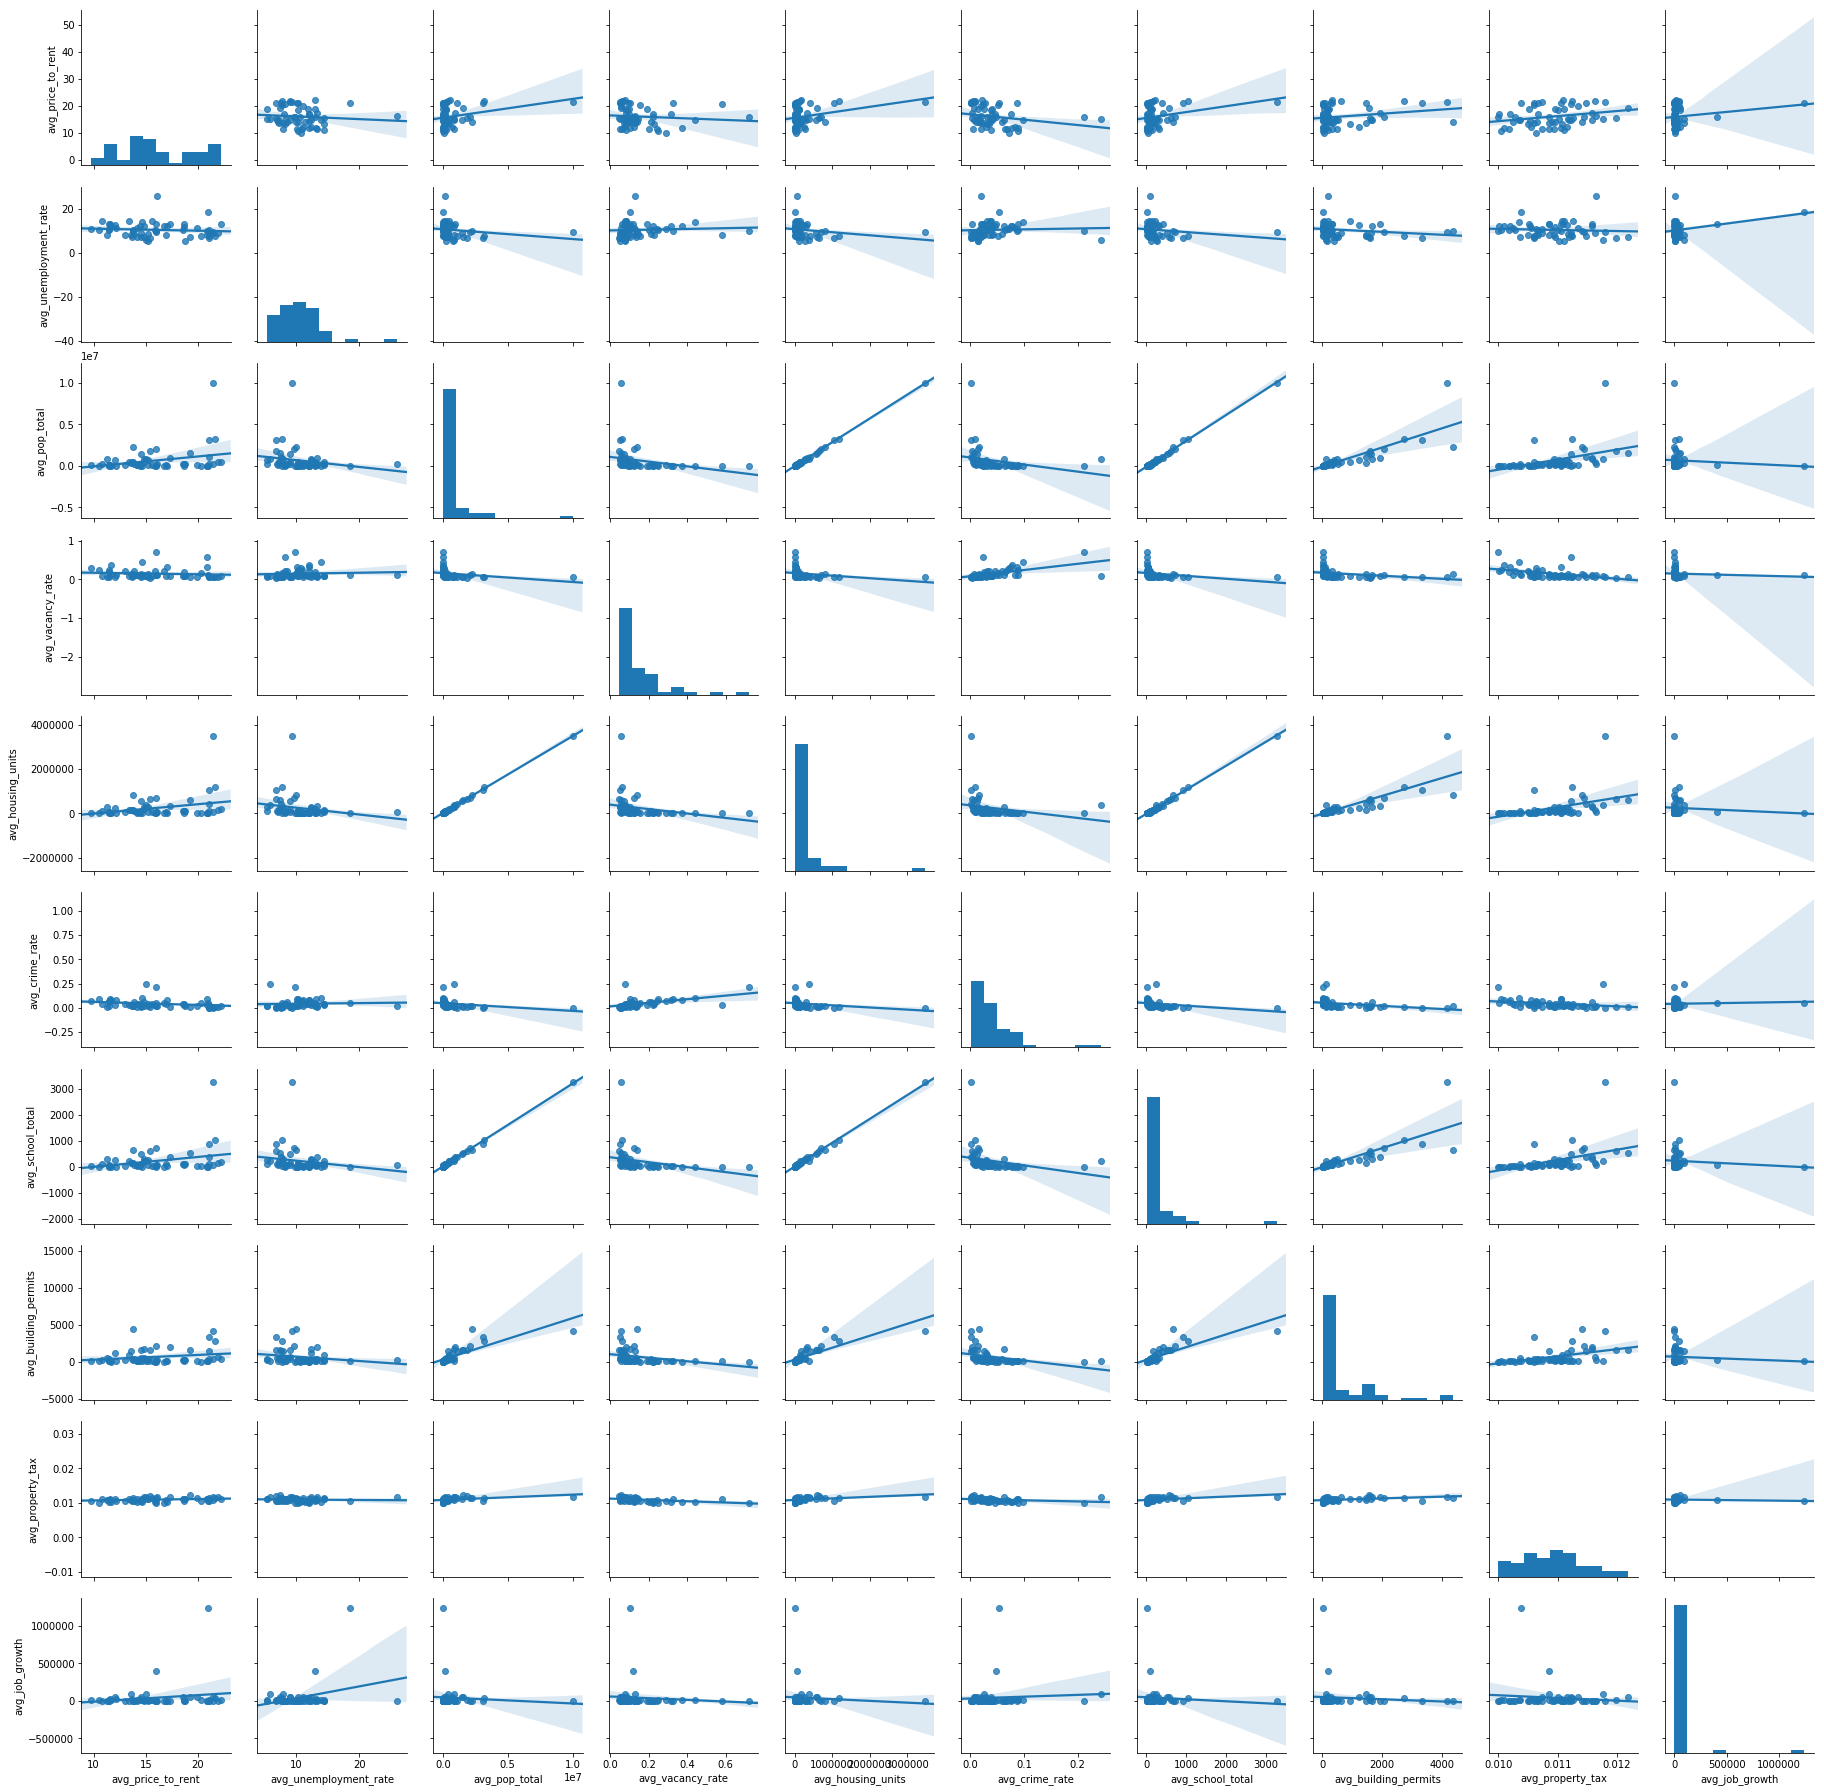

In [333]:
# plot dataframe into seaborn pairplot to find potential correlations between data (avg. 2010-2016)
plt.rcParams['figure.figsize']=(20,20)
sns.pairplot(ca_market_data,kind="reg")

Possible correlations:

A) Positive

Price-to-rent vs : Population Total, Housing Units, School Total, Building Permits, Property Tax

B) Negative

Price-to-rent vs : Unemployment Rate, Vacancy Rate, Crime Rate

## Comparing Data (2010-2016) using Central Limit Theorem

### Price-to-rent vs :

#### 1) Total Population

In [339]:
pr_mean = ca_pr.iloc[:,7:82].mean(axis=1)
print(pr_mean)

0       19.242133
1       15.930933
2       11.487467
3       21.009333
4       20.875200
5       20.916533
6       21.068800
7       12.108000
8       13.870800
9       17.320133
10      14.428667
11      16.939067
12      16.083200
13      20.312267
14      14.794533
15      11.468533
16      11.511467
17      15.872667
18      21.463067
19      15.977467
20      18.724400
21      10.547067
22      15.173200
23      10.840133
24      16.778000
25      20.826800
26      13.781333
27      14.127200
28      13.040267
29      21.077067
30      13.552933
31      14.627867
32      13.795867
33      14.524667
34      19.910000
35      15.990400
36      21.610933
37      15.062267
38      12.093200
39      14.584400
40      15.228267
41      13.694800
42      15.369333
43      18.584533
44      18.624267
45      11.657733
46      18.630933
47      21.925200
48      14.816000
49      22.204800
50      15.546000
51      14.122800
52      17.044800
53      13.409333
54       9.751200
55      11